# Exact solution used in MES runs


We would like to MES Laplacian inversions algorithm using cylindrical geometry

In [1]:
%matplotlib notebook

from sympy import init_printing
from sympy import S
from sympy import sin, cos, tanh, exp, pi, sqrt

from boutdata.mms import Delp2, DDX, DDY, DDZ
from boutdata.mms import x, y, z, t

import os, sys
# If we add to sys.path, then it must be an absolute path
common_dir = os.path.abspath('./../../../')
# Sys path is a list of system paths
sys.path.append(common_dir)
from CELMAPy.MES import get_metric, make_plot, BOUT_print

init_printing()

## Initialize

In [2]:
folder = '../twoGaussians/'
metric = get_metric()

## Define the variables

In [3]:
# Initialization
the_vars = {}

We have that

$$\Omega^D = \nabla\cdot(n\nabla_\perp\phi) = n\nabla_\perp^2\phi + \nabla n\cdot \nabla_\perp \phi = n\nabla_\perp^2\phi + \nabla_\perp n\cdot \nabla_\perp \phi$$

Due to orthogonality we have that
$$\nabla_\perp n\cdot \nabla_\perp \phi = \mathbf{e}^i\cdot \mathbf{e}^i(\partial_i n)(\partial_i \phi)
 = g^{xx}(\partial_x n)(\partial_x \phi) + g^{zz}(\partial_z n)(\partial_z \phi) = (\partial_x n)(\partial_x \phi) + \frac{1}{x^2}(\partial_z n)(\partial_z \phi)$$
 
We will use the `Delp2` operator for the perpendicular Laplace operator (as the y-derivatives vanishes). We have

`Delp2`$(f)=g^{xx}\partial_x^2 f + g^{zz}\partial_z^2 f + 2g^{xz}\partial_x\partial_z f + G^1\partial_x f + G^3\partial_z f$

Using the cylinder geometry, we get that

`Delp2`$(f)=\partial_x^2 f + \frac{1}{x^2}\partial_z^2 f + \frac{1}{x}\partial_x f$

This gives

$$\Omega^D = \nabla\cdot(n\nabla_\perp\phi) = n\partial_x^2 \phi + n\frac{1}{x^2}\partial_z^2 \phi + n\frac{1}{x}\partial_x \phi + (\partial_x n)(\partial_x \phi) + \frac{1}{x^2}(\partial_z n)(\partial_z \phi)$$

**NOTE**:

1. z must be periodic
2. The field $f(\rho, \theta)$ must be of class infinity in $z=0$ and $z=2\pi$
3. The field $f(\rho, \theta)$ must be single valued when $\rho\to0$
4. The field $f(\rho, \theta)$ must be continuous in the $\rho$ direction with $f(\rho, \theta + \pi)$
5. Eventual BC in $\rho$ must be satisfied

In [4]:
# We need Lx
from boututils.options import BOUTOptions
myOpts = BOUTOptions(folder)
Lx = eval(myOpts.geom['Lx'])

In [5]:
# Two gaussians

# The skew sinus
# In cartesian coordinates we would like a sinus with with a wave-vector in the direction
# 45 degrees with respect to the first quadrant. This can be achieved with a wave vector
# k = [1/sqrt(2), 1/sqrt(2)]
# sin((1/sqrt(2))*(x + y))
# We would like 2 nodes, so we may write
# sin((1/sqrt(2))*(x + y)*(2*pi/(2*Lx)))
# Rewriting this to cylindrical coordinates, gives
# sin((1/sqrt(2))*(x*(cos(z)+sin(z)))*(2*pi/(2*Lx)))

# The gaussian
# In cartesian coordinates we would like
# f = exp(-(1/(2*w^2))*((x-x0)^2 + (y-y0)^2))
# In cylindrical coordinates, this translates to
# f = exp(-(1/(2*w^2))*(x^2 + y^2 + x0^2 + y0^2 - 2*(x*x0+y*y0) ))
#   = exp(-(1/(2*w^2))*(rho^2 + rho0^2 - 2*rho*rho0*(cos(theta)*cos(theta0)+sin(theta)*sin(theta0)) ))
#   = exp(-(1/(2*w^2))*(rho^2 + rho0^2 - 2*rho*rho0*(cos(theta - theta0)) ))

# A parabola
# In cartesian coordinates, we have
# ((x-x0)/Lx)^2
# Chosing this function to have a zero value at the edge yields in cylindrical coordinates
# ((x*cos(z)+Lx)/(2*Lx))^2
# +2 to ensure positivity of n

w = 0.8*Lx
rho0 = 0.3*Lx
theta0 = 5*pi/4
the_vars['n'] = sin((1/sqrt(2))*(x*(cos(z)+sin(z)))*(2*pi/(2*Lx)))*\
                  exp(-(1/(2*w**2))*(x**2 + rho0**2 - 2*x*rho0*(cos(z - theta0)) ))*\
                  ((x*cos(z)+Lx)/(2*Lx))**2\
                  +2

# The gaussian

# In cartesian coordinates we would like
# f = exp(-(1/(2*w^2))*((x-x0)^2 + (y-y0)^2))
# In cylindrical coordinates, this translates to
# f = exp(-(1/(2*w^2))*(x^2 + y^2 + x0^2 + y0^2 - 2*(x*x0+y*y0) ))
#   = exp(-(1/(2*w^2))*(rho^2 + rho0^2 - 2*rho*rho0*(cos(theta)*cos(theta0)+sin(theta)*sin(theta0)) ))
#   = exp(-(1/(2*w^2))*(rho^2 + rho0^2 - 2*rho*rho0*(cos(theta - theta0)) ))
# Multiplication of cos(pi*x/(2*Lx)) to give zero boundaries

w = 0.5*Lx
rho0 = 0.2*Lx
theta0 = pi
the_vars[r'$\phi$'] = exp(-(1/(2*w**2))*(x**2 + rho0**2 - 2*x*rho0*(cos(z - theta0)) ))*cos(pi*x/(2*Lx))

We have that

$$\Omega^D = \nabla\cdot(n\nabla_\perp(\phi))$$

In [6]:
# Calculate the solution
the_vars['vortD'] =   the_vars['n']*Delp2(the_vars[r'$\phi$'], metric=metric)\
                    + metric.g11*DDX(the_vars['n'], metric=metric)*DDX(the_vars[r'$\phi$'], metric=metric)\
                    + metric.g33*DDZ(the_vars['n'], metric=metric)*DDZ(the_vars[r'$\phi$'], metric=metric)

## Plot

<IPython.core.display.Javascript object>


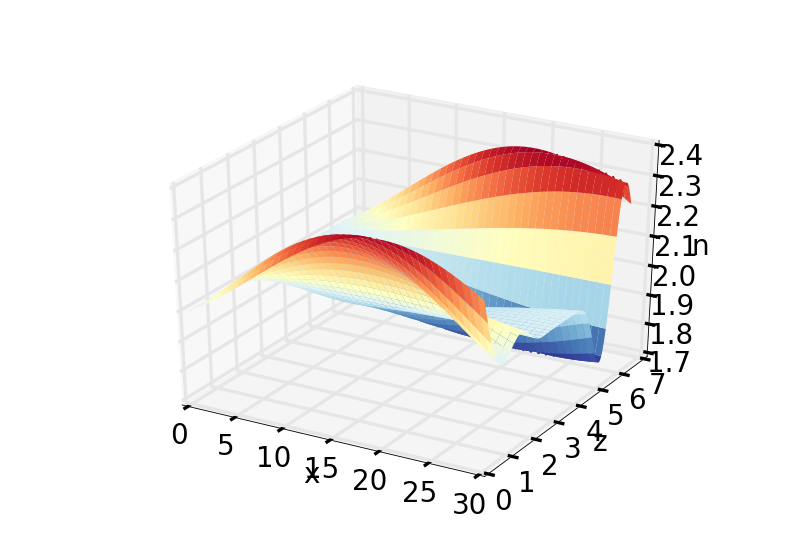

<IPython.core.display.Javascript object>


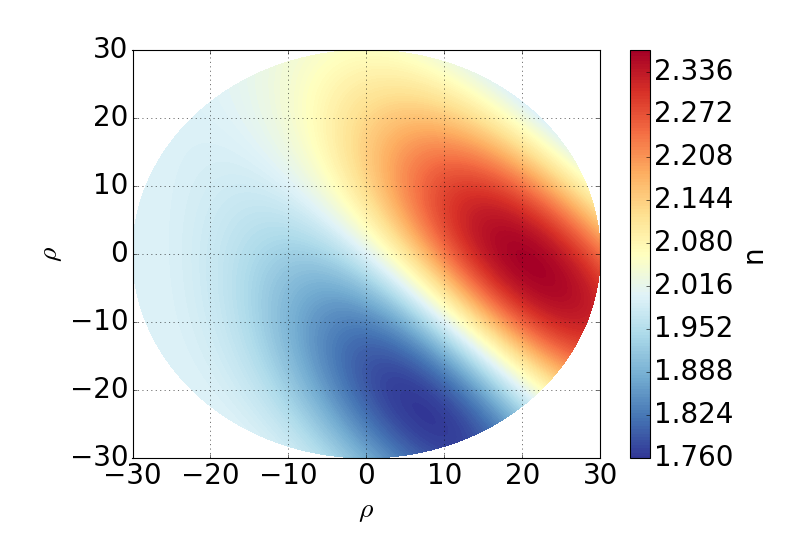

<IPython.core.display.Javascript object>


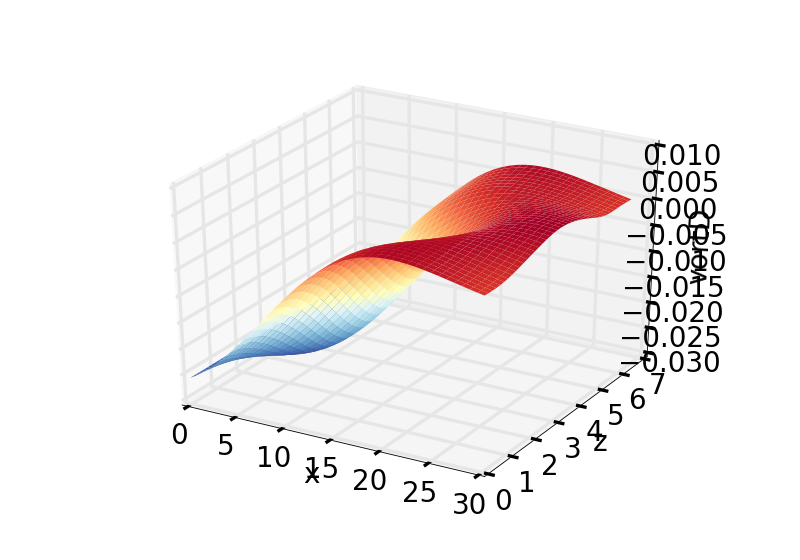

<IPython.core.display.Javascript object>


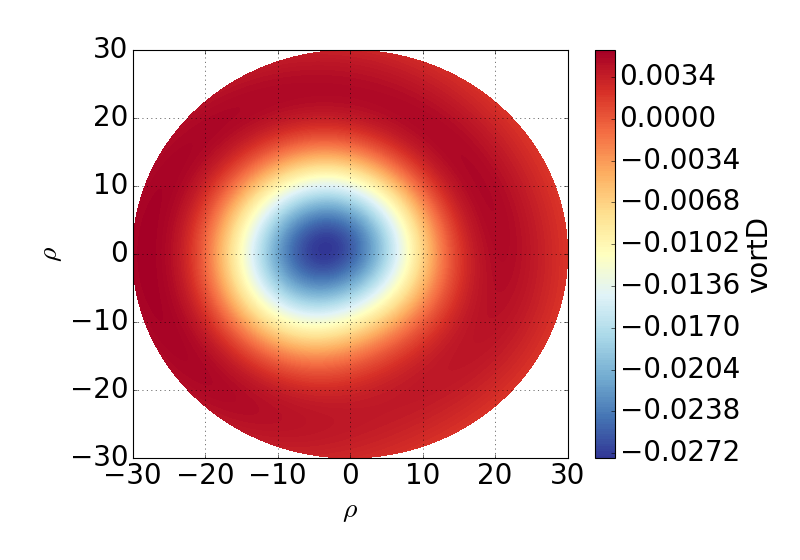

<IPython.core.display.Javascript object>


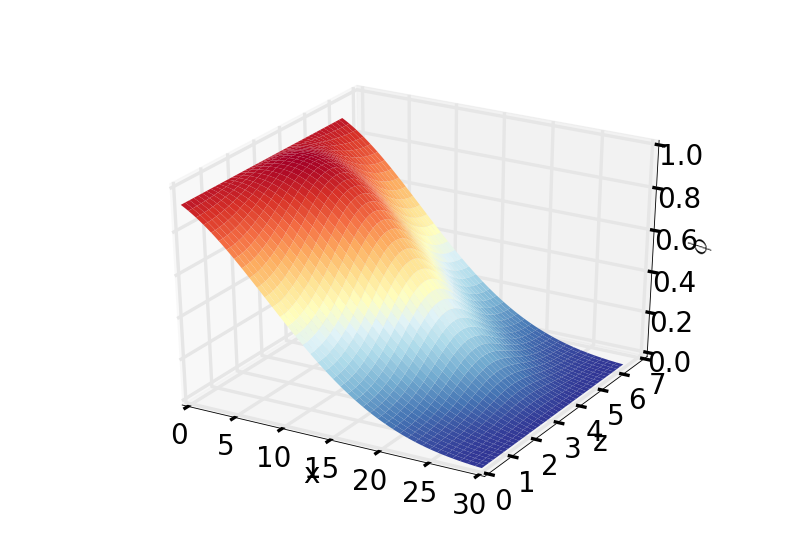

<IPython.core.display.Javascript object>


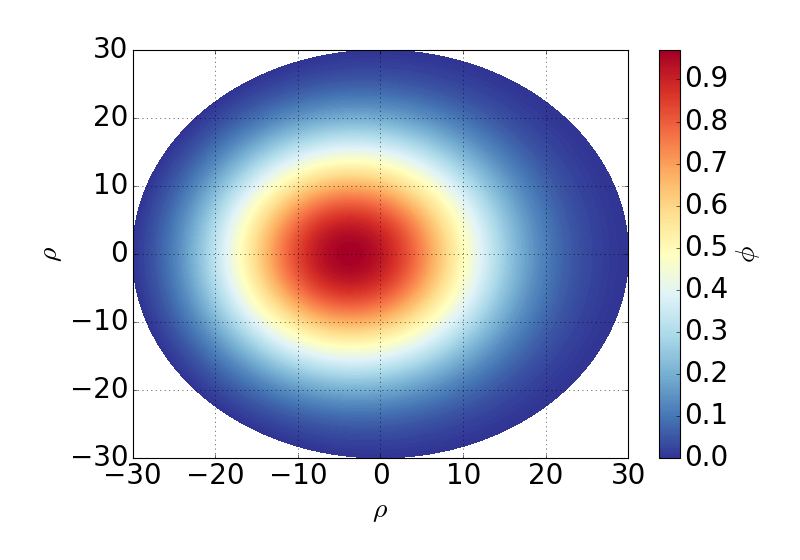

In [7]:
make_plot(folder=folder, the_vars=the_vars, plot2d=True, include_aux=False, save = True)

## Print the variables in BOUT++ format

In [8]:
BOUT_print(the_vars, rational=False)


[n]
0.932102492359528*(geom:xl*cos(z)/60 + 1/2)^2*exp(-0.000868055555555556*geom:xl^2 - 0.015625*geom:xl*sin(z + pi/4))*sin(sqrt(2)*pi*geom:xl*(sin(z) + cos(z))/60) + 2

[vortD]
(0.923116346386636*(-0.00444444444444444*geom:xl - 0.0266666666666667*cos(z))*exp(-0.00222222222222222*geom:xl^2 - 0.0266666666666667*geom:xl*cos(z))*cos(pi*geom:xl/60) - 0.0153852724397773*pi*exp(-0.00222222222222222*geom:xl^2 - 0.0266666666666667*geom:xl*cos(z))*sin(pi*geom:xl/60))*(0.932102492359528*(-0.00173611111111111*geom:xl - 0.015625*sin(z + pi/4))*(geom:xl*cos(z)/60 + 1/2)^2*exp(-0.000868055555555556*geom:xl^2 - 0.015625*geom:xl*sin(z + pi/4))*sin(sqrt(2)*pi*geom:xl*(sin(z) + cos(z))/60) + 0.0155350415393255*sqrt(2)*pi*(geom:xl*cos(z)/60 + 1/2)^2*(sin(z) + cos(z))*exp(-0.000868055555555556*geom:xl^2 - 0.015625*geom:xl*sin(z + pi/4))*cos(sqrt(2)*pi*geom:xl*(sin(z) + cos(z))/60) + 0.0310700830786509*(geom:xl*cos(z)/60 + 1/2)*exp(-0.000868055555555556*geom:xl^2 - 0.015625*geom:xl*sin(z + pi/4))*sin(sqrt